In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (150,150,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.02

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,n-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0+0.01,pos-0.01,0), 4, myocardium)
# test_phantom.add_tissue_sphere((-pos,2*pos,0), 6, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


(115, 75, 50)
(95, 95, 50)


514


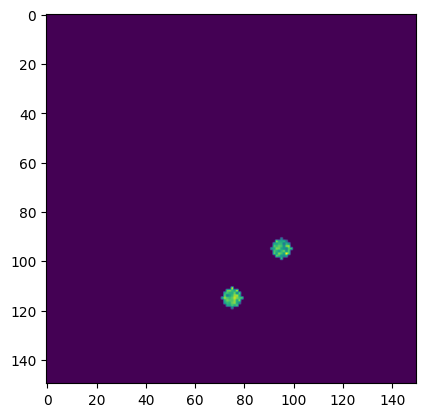

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [4]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

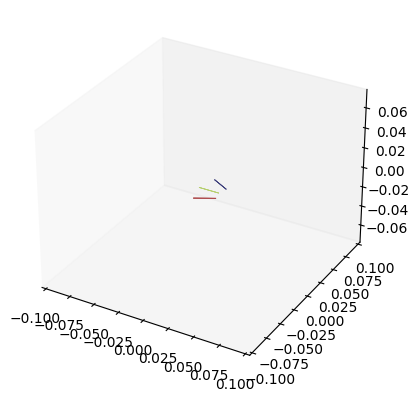

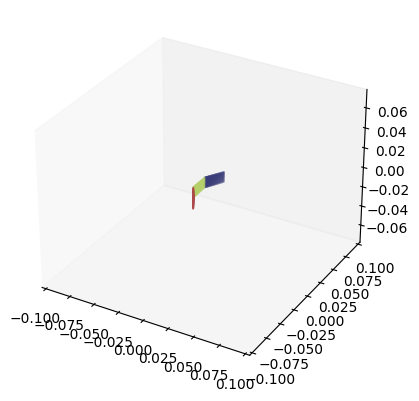

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))
cont_transducer_set.assign_pose(1, geometry.Transform(translation=[-0.005,0,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-2*np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([2*np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

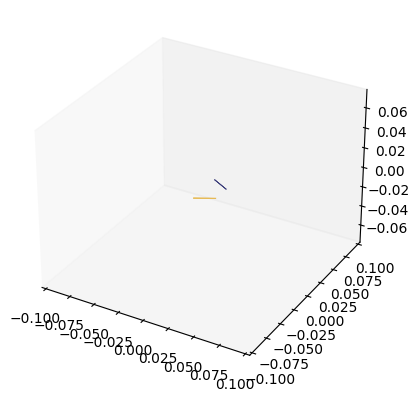

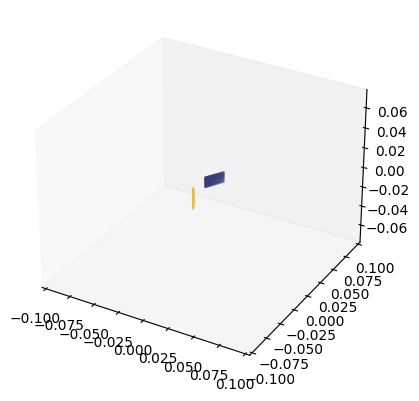

In [6]:
num_transducers = 2
transducers_copy = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers_copy:
    t.make_sensor_coords(test_phantom.baseline[0])
gap_transducer_set = transducer_set.TransducerSet(transducers_copy, seed=8888)
gap_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
gap_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))

gap_transducer_set.plot_transducer_fovs(scale=0.1)
gap_transducer_set.plot_transducer_coords(scale=0.1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


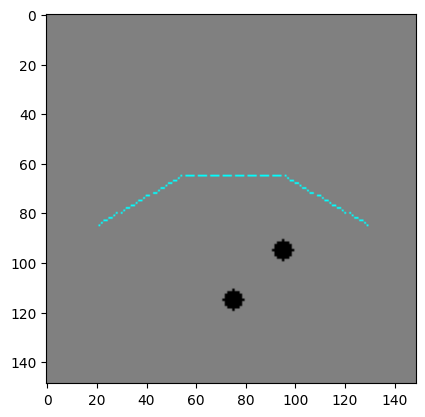

In [7]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')
gap_sensor = sensor.Sensor(transducer_set=gap_transducer_set, aperture_type='extended_aperture')
gm = extended_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

#gm2 = gap_sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

In [8]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [9]:
extended_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/extended_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/tar_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

gap_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/gap_experiment_ea',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = gap_transducer_set,
                 sensor          = gap_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

extended_experiment.save()
tar_experiment.save()
gap_experiment.save()

In [ ]:
gap_experiment.plot_ray_path(0)

In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

In [10]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

running with 1 workers



preparation for sim    0 completed in            2.51 seconds

preparation for sim    1 completed in            2.51 seconds



preparation for sim    2 completed in            2.55 seconds

simulation      0 completed in  4.58 seconds


preparation for sim    3 completed in            2.44 seconds

simulation      1 completed in  4.44 seconds
preparation for sim    4 completed in            2.51 seconds



preparation for sim    5 completed in            2.59 seconds

simulation      2 completed in  4.47 seconds
preparation for sim    6 completed in            2.82 seconds



preparation for sim    7 completed in            2.53 seconds

simulation      3 completed in  4.58 seconds


simulation      4 completed in  4.33 seconds
preparation for sim    8 completed in            2.44 seconds



preparation for sim    9 completed in            2.47 seconds

simulation      5 completed in  4.66 seconds


simulation      6 completed in  4.36 seconds


preparation for sim   10 completed in            2.53 seconds

simulation      7 completed in  4.63 seconds
preparation for sim   11 completed in            2.41 seconds



preparation for sim   12 completed in            2.52 seconds

simulation      8 completed in  4.54 seconds


simulation      9 completed in  4.38 seconds
preparation for sim   13 completed in            2.44 seconds



preparation for sim   14 completed in            2.53 seconds

simulation     10 completed in  4.67 seconds


simulation     11 completed in  4.23 seconds


preparation for sim   15 completed in            2.46 seconds

simulation     12 completed in  4.68 seconds
preparation for sim   16 completed in            2.56 seconds



preparation for sim   17 completed in            2.50 seconds

simulation     13 completed in  4.45 seconds


simulation     14 completed in  4.38 seconds
preparation for sim   18 completed in            2.40 seconds



preparation for sim   19 completed in            2.52 seconds

simulation     15 completed in  4.69 seconds


simulation     16 completed in  4.22 seconds
preparation for sim   20 completed in            2.49 seconds



preparation for sim   21 completed in            2.47 seconds

simulation     17 completed in  4.56 seconds


simulation     18 completed in  4.23 seconds


preparation for sim   22 completed in            2.58 seconds

simulation     19 completed in  4.66 seconds
preparation for sim   23 completed in            2.91 seconds



preparation for sim   24 completed in            2.53 seconds

simulation     20 completed in  4.68 seconds


simulation     21 completed in  4.45 seconds
preparation for sim   25 completed in            2.52 seconds



preparation for sim   26 completed in            2.54 seconds

simulation     22 completed in  4.74 seconds


simulation     23 completed in  4.36 seconds


preparation for sim   27 completed in            2.49 seconds

simulation     24 completed in  4.70 seconds
preparation for sim   28 completed in            2.45 seconds



preparation for sim   29 completed in            2.52 seconds

simulation     25 completed in  4.56 seconds


simulation     26 completed in  4.38 seconds
preparation for sim   30 completed in            2.42 seconds



preparation for sim   31 completed in            2.55 seconds

simulation     27 completed in  4.73 seconds


simulation     28 completed in  4.37 seconds
preparation for sim   32 completed in            2.58 seconds



preparation for sim   33 completed in            2.53 seconds

simulation     29 completed in  4.71 seconds


simulation     30 completed in  4.37 seconds


preparation for sim   34 completed in            2.54 seconds

simulation     31 completed in  4.55 seconds
preparation for sim   35 completed in            2.41 seconds



preparation for sim   36 completed in            2.53 seconds

simulation     32 completed in  4.71 seconds


simulation     33 completed in  4.40 seconds
preparation for sim   37 completed in            2.42 seconds



preparation for sim   38 completed in            2.54 seconds

simulation     34 completed in  4.71 seconds


simulation     35 completed in  4.39 seconds
preparation for sim   39 completed in            2.43 seconds



preparation for sim   40 completed in            2.48 seconds

simulation     36 completed in  4.45 seconds


simulation     37 completed in  4.40 seconds


preparation for sim   41 completed in            2.54 seconds

simulation     38 completed in  4.70 seconds
preparation for sim   42 completed in            2.42 seconds



preparation for sim   43 completed in            2.54 seconds

simulation     39 completed in  4.73 seconds


simulation     40 completed in  4.36 seconds
preparation for sim   44 completed in            2.40 seconds



preparation for sim   45 completed in            2.51 seconds

simulation     41 completed in  4.70 seconds


simulation     42 completed in  4.41 seconds
preparation for sim   46 completed in            2.53 seconds



preparation for sim   47 completed in            2.50 seconds

simulation     43 completed in  4.64 seconds


simulation     44 completed in  4.36 seconds


preparation for sim   48 completed in            2.56 seconds

simulation     45 completed in  4.74 seconds
preparation for sim   49 completed in            2.44 seconds



preparation for sim   50 completed in            2.54 seconds

simulation     46 completed in  4.68 seconds


simulation     47 completed in  4.38 seconds
preparation for sim   51 completed in            2.39 seconds



preparation for sim   52 completed in            2.50 seconds

simulation     48 completed in  4.72 seconds


simulation     49 completed in  4.40 seconds
preparation for sim   53 completed in            2.53 seconds



preparation for sim   54 completed in            2.56 seconds

simulation     50 completed in  4.71 seconds


simulation     51 completed in  4.38 seconds


preparation for sim   55 completed in            2.50 seconds

simulation     52 completed in  4.50 seconds
preparation for sim   56 completed in            2.43 seconds



preparation for sim   57 completed in            2.55 seconds

simulation     53 completed in  4.68 seconds


simulation     54 completed in  4.22 seconds
preparation for sim   58 completed in            2.64 seconds



preparation for sim   59 completed in            2.57 seconds

simulation     55 completed in  4.72 seconds


simulation     56 completed in  4.21 seconds


preparation for sim   60 completed in            2.42 seconds

simulation     57 completed in  4.72 seconds
preparation for sim   61 completed in            2.52 seconds



preparation for sim   62 completed in            2.53 seconds

simulation     58 completed in  4.54 seconds


simulation     59 completed in  4.39 seconds
preparation for sim   63 completed in            2.42 seconds



preparation for sim   64 completed in            2.52 seconds

simulation     60 completed in  4.70 seconds


simulation     61 completed in  4.25 seconds
preparation for sim   65 completed in            2.52 seconds



preparation for sim   66 completed in            2.50 seconds

simulation     62 completed in  4.60 seconds


simulation     63 completed in  4.38 seconds


preparation for sim   67 completed in            2.57 seconds

simulation     64 completed in  4.71 seconds
preparation for sim   68 completed in            2.42 seconds



preparation for sim   69 completed in            2.52 seconds

simulation     65 completed in  4.68 seconds


simulation     66 completed in  4.39 seconds
preparation for sim   70 completed in            2.42 seconds



preparation for sim   71 completed in            2.54 seconds

simulation     67 completed in  4.70 seconds


simulation     68 completed in  4.39 seconds
preparation for sim   72 completed in            2.47 seconds



preparation for sim   73 completed in            2.50 seconds

simulation     69 completed in  4.71 seconds


simulation     70 completed in  4.25 seconds


preparation for sim   74 completed in            2.53 seconds

simulation     71 completed in  4.66 seconds
preparation for sim   75 completed in            2.42 seconds



preparation for sim   76 completed in            2.53 seconds

simulation     72 completed in  4.71 seconds


simulation     73 completed in  4.40 seconds
preparation for sim   77 completed in            2.41 seconds



preparation for sim   78 completed in            2.53 seconds

simulation     74 completed in  4.72 seconds


simulation     75 completed in  4.41 seconds
preparation for sim   79 completed in            2.58 seconds



preparation for sim   80 completed in            2.50 seconds

simulation     76 completed in  4.71 seconds


simulation     77 completed in  4.24 seconds


preparation for sim   81 completed in            2.52 seconds

simulation     78 completed in  4.74 seconds
preparation for sim   82 completed in            2.42 seconds



preparation for sim   83 completed in            2.54 seconds

simulation     79 completed in  4.69 seconds


simulation     80 completed in  4.24 seconds
preparation for sim   84 completed in            2.42 seconds



preparation for sim   85 completed in            2.53 seconds

simulation     81 completed in  4.71 seconds


simulation     82 completed in  4.39 seconds
preparation for sim   86 completed in            2.42 seconds



preparation for sim   87 completed in            2.48 seconds

simulation     83 completed in  4.58 seconds


simulation     84 completed in  4.40 seconds


preparation for sim   88 completed in            2.48 seconds

simulation     85 completed in  4.71 seconds
preparation for sim   89 completed in            2.42 seconds



simulation     86 completed in  4.38 seconds


simulation     87 completed in  4.39 seconds


simulation     88 completed in  4.42 seconds


simulation     89 completed in  4.37 seconds


In [ ]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

# Reconstruction

In [11]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 12.03it/s]


In [12]:
image1 = test_reconstruction.compound(workers=24, resolution_multiplier=1.5, local=True)

100%|██████████| 90/90 [00:00<00:00, 1137010.12it/s]


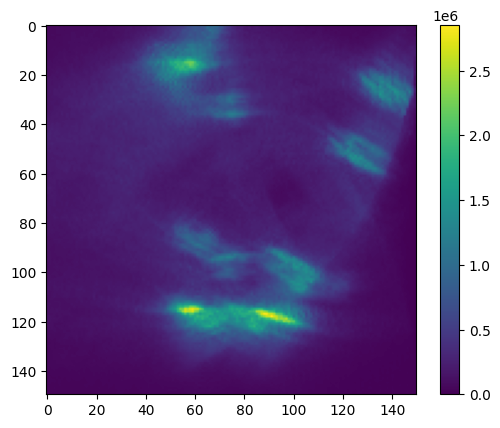

In [13]:
plt.imshow(image1[:,:,image1.shape[2]//2])
plt.colorbar()

In [14]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


In [15]:
image2 = test_reconstruction.compound(workers=24, resolution_multiplier=1.5, local=True)

100%|██████████| 90/90 [00:00<00:00, 1037053.19it/s]


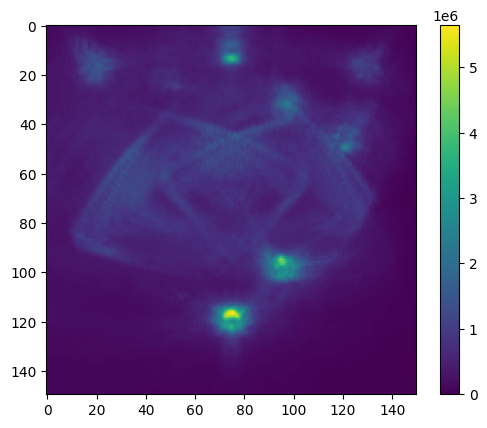

In [16]:
plt.imshow(image2[:,:,image2.shape[2]//2])
plt.colorbar()

In [17]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 12.54it/s]


In [18]:
image3 = test_reconstruction.compound(workers=24, resolution_multiplier=1.5, local=True)

100%|██████████| 60/60 [00:00<00:00, 905245.47it/s]


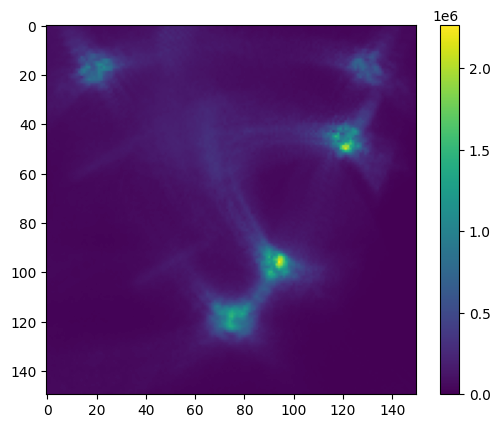

In [19]:
plt.imshow(image3[:,:,image3.shape[2]//2])
plt.colorbar()